#  Calculate timeseries of Chl a
Author: Yuchen Li

Date: 4-13-2024

About: GlobColour level 3 Chl a product from multiple sensor sources

In [83]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd


def moving_mean(data, n):
    """
    Calculate the running mean of a sequence with a specified window size using np.convolve.

    Args:
    - data (list or numpy array): The input sequence.
    - n (int): The size of the window.

    Returns:
    - numpy array: An array containing the running mean values.
    """
    # Define a boxcar filter with the specified window size
    boxcar_filter = np.ones(n) / n

    # Use np.convolve to calculate the running mean
    moving_mean = np.convolve(data, boxcar_filter, mode='valid')
    
    return moving_mean


## Preprocessing

In [22]:
# retrieve files 
avw_files = []
gsm_files = []

directory = "/Users/yuchenli/Documents/Stanford@SEA/project/data/chlorophyll/"
for filename in os.listdir(directory):
    if "_AVW" in filename:
        avw_files.append(os.path.join(directory, filename))
    elif "_GSM" in filename:
        gsm_files.append(os.path.join(directory, filename))

# Open and merge _AVW files into a single xarray dataset
if avw_files:
    avw_datasets = []
    for file in sorted(avw_files):
        # Extract time from filename
        time_str = file.split('_')[1]
        year = int(time_str[:4])
        month = int(time_str[4:6])
        day = int(time_str[6:8])
        # Create time variable
        time = xr.DataArray([pd.to_datetime(f"{year}-{month}-{day}")], dims='time')
        avw_data = xr.open_dataset(file)
        avw_data['time'] = time
        avw_datasets.append(avw_data)
    avw_dataset = xr.concat(avw_datasets, dim='time')

# Open and merge _GSM files into a single xarray dataset
if gsm_files:
    gsm_datasets = []
    for file in sorted(gsm_files):
        # Extract time from filename
        time_str = file.split('_')[1]
        year = int(time_str[:4])
        month = int(time_str[4:6])
        day = int(time_str[6:8])
        # Create time variable
        time = xr.DataArray([pd.to_datetime(f"{year}-{month}-{day}")], dims='time')
        gsm_data = xr.open_dataset(file)
        gsm_data['time'] = time
        gsm_datasets.append(gsm_data)
    gsm_dataset = xr.concat(gsm_datasets, dim='time')


In [23]:
gsm_dataset

<xarray.Dataset>
Dimensions:     (lat: 169, lon: 314, time: 1222)
Coordinates:
  * lat         (lat) float32 -5.979 -6.021 -6.063 ... -12.9 -12.94 -12.98
  * lon         (lon) float32 -146.0 -146.0 -145.9 ... -133.1 -133.0 -133.0
  * time        (time) datetime64[ns] 1997-09-06 1997-09-14 ... 2024-03-29
Data variables:
    CHL1_mean   (time, lat, lon) float32 0.1241 0.1238 0.1242 ... 0.1586 0.1484
    CHL1_flags  (time, lat, lon) float32 1.043e+04 1.043e+04 ... 2.272e+04
    CHL1_error  (time, lat, lon) float32 39.17 39.56 39.83 ... 10.03 11.7 16.48
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour 8-day SeaWiFS product
    product_name:               L3m_19970906-19970913__838617517_4_GSM-SWF_CH...
    product_type:               8-day
    product_version:            2018.4
    product_level:              3
    ...                         ...
    references:                 http://www.globcolour.info
    contact:                    service@globcolour.info
    copyright:                  Copyright ACRI-ST - GlobColour. GlobColour ha...
    history:                    20240412T230728Z: globcolour_l3_extract.sh -i...
    input_files:                S1997249160807.L2_GAC_OC.nc,S1997252182317.L2...
    input_files_reprocessings:  2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,201...

In [24]:
avw_dataset

<xarray.Dataset>
Dimensions:     (lat: 169, lon: 314, time: 1007)
Coordinates:
  * lat         (lat) float32 -5.979 -6.021 -6.063 ... -12.9 -12.94 -12.98
  * lon         (lon) float32 -146.0 -146.0 -145.9 ... -133.1 -133.0 -133.0
  * time        (time) datetime64[ns] 2002-05-01 2002-05-09 ... 2024-03-29
Data variables:
    CHL1_mean   (time, lat, lon) float32 0.1173 0.1332 0.1247 ... 0.1035 0.1018
    CHL1_flags  (time, lat, lon) float32 1.043e+04 1.043e+04 ... 2.272e+04
    CHL1_error  (time, lat, lon) float32 23.1 20.28 18.37 ... 14.25 15.78 21.65
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour 8-day merged MERIS/SeaWiFS product
    product_name:               L3m_20020501-20020508__838617517_4_AVW-MERSWF...
    product_type:               8-day
    product_version:            2018.4
    product_level:              3
    ...                         ...
    references:                 http://www.globcolour.info
    contact:                    service@globcolour.info
    copyright:                  Copyright ACRI-ST - GlobColour. GlobColour ha...
    history:                    20240412T230937Z: globcolour_l3_extract.sh -i...
    input_files:                MER_RR__2PNACR20020430_204951_000026372005_00...
    input_files_reprocessings:  MEGS/8.0     L,MEGS/8.0     L,MEGS/8.0     L,...

In [25]:
# save the datasets
avw_dataset.to_netcdf('../data/chlorophyll/ChlA_20020501-20240329_AVW.nc')
gsm_dataset.to_netcdf('../data/chlorophyll/ChlA_19970906-20240329_GSM.nc')


## Analysis

In [103]:
ds = xr.open_dataset('../data/chlorophyll/ChlA_19970906-20240329_GSM.nc')
chla = ds.CHL1_mean
ds

<xarray.Dataset>
Dimensions:     (lat: 169, lon: 314, time: 1222)
Coordinates:
  * lat         (lat) float32 -5.979 -6.021 -6.063 ... -12.9 -12.94 -12.98
  * lon         (lon) float32 -146.0 -146.0 -145.9 ... -133.1 -133.0 -133.0
  * time        (time) datetime64[ns] 1997-09-06 1997-09-14 ... 2024-03-29
Data variables:
    CHL1_mean   (time, lat, lon) float32 ...
    CHL1_flags  (time, lat, lon) float32 ...
    CHL1_error  (time, lat, lon) float32 ...
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      GlobColour 8-day SeaWiFS product
    product_name:               L3m_19970906-19970913__838617517_4_GSM-SWF_CH...
    product_type:               8-day
    product_version:            2018.4
    product_level:              3
    ...                         ...
    references:                 http://www.globcolour.info
    contact:                    service@globcolour.info
    copyright:                  Copyright ACRI-ST - GlobColour. GlobColour ha...
    history:                    20240412T230728Z: globcolour_l3_extract.sh -i...
    input_files:                S1997249160807.L2_GAC_OC.nc,S1997252182317.L2...
    input_files_reprocessings:  2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,201...

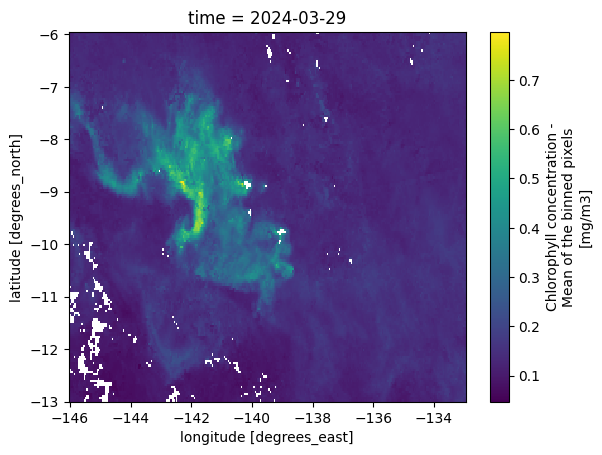

In [104]:
chla[-1].plot()

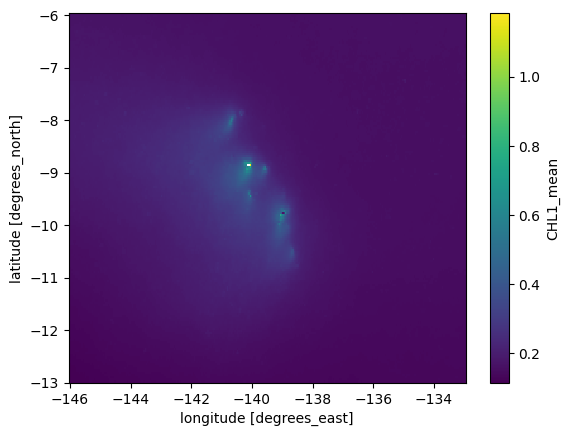

In [105]:
mean_chla = ds.CHL1_mean.mean(dim='time')
mean_chla.plot()

Calculate mean Chl a over 218°E–222°E and 8°S–11°S (Martinez and Maamaatuaiahutapu 2004)
1. Naively (ignoring NaN)
2. Using NaN threshold

In [88]:
chla_region = ds.CHL1_mean.sel(lat=slice(-8, -11), lon=slice(-142, 138))

# take the area-weighted average
weights = np.cos(np.deg2rad(chla_region.lat))
chla_naive_avg = chla_region.weighted(weights).mean(dim=['lat', 'lon'])

# if there is not enough data, remove 
nan_counts = chla_region.isnull().sum(dim=('lat', 'lon'))
total_points = np.size(chla_region[0])

# threshold for greatest allowed proportion of missing data 
thresh = 0.3
missing_data_mask = nan_counts/total_points <= thresh
chla_avg = chla_naive_avg.where(missing_data_mask, other=np.nan)

In [93]:
# ENSO index
# nino34 = xr.open_dataset('../data/global_omi_climate-variability_nino34_sst_anom_19930115_P20220427_R19932014.nc').sst_mean
# nino34

ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCDC/.OISST/.version2p1/.AVHRR_monthly/.anom_c9120/dods', decode_times=False)
ds

<xarray.Dataset>
Dimensions:     (lat: 720, lon: 1440, T: 510, zlev: 1)
Coordinates:
  * lat         (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon         (lon) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * T           (T) float32 260.5 261.5 262.5 263.5 ... 766.5 767.5 768.5 769.5
  * zlev        (zlev) float32 0.0
Data variables:
    anom_c9120  (T, zlev, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

Text(0, 0.5, 'mg/m^3')

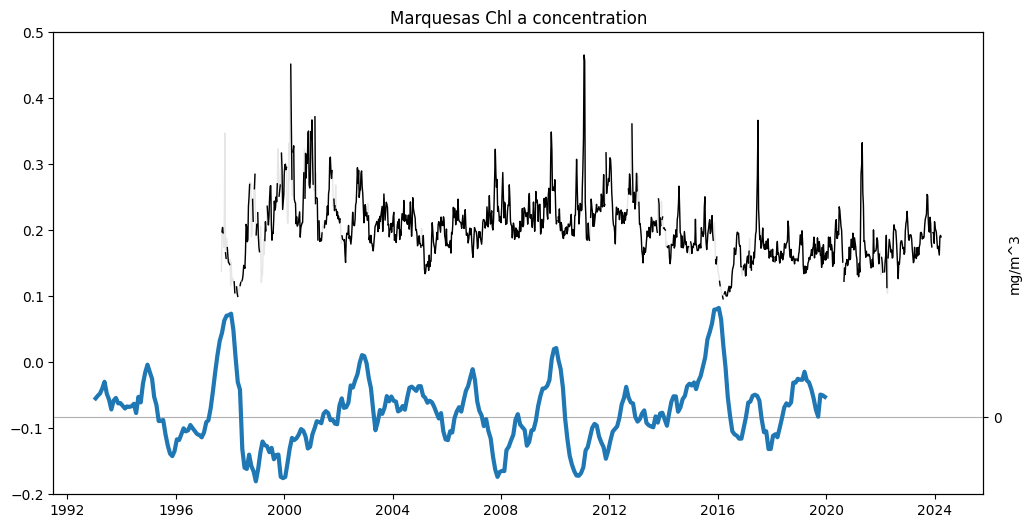

In [82]:
plt.figure(figsize=(12,6))
time = chla_naive_avg.time
plt.plot(time, chla_naive_avg, linewidth=1, color=(0.9,0.9,0.9))
plt.plot(time, chla_avg, linewidth=1, color='k')
plt.ylim(-0.2,0.5)

plt.twinx()
plt.plot(nino34.time, nino34, linewidth=3)
plt.ylim(-2,10)
plt.yticks([0])

plt.grid(True)
plt.title('Marquesas Chl a concentration')
plt.ylabel('mg/m^3')


/var/folders/3n/bmln3m1s2b15c_dvp93gxmlr0000gn/T/ipykernel_7589/2105390781.py:6: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


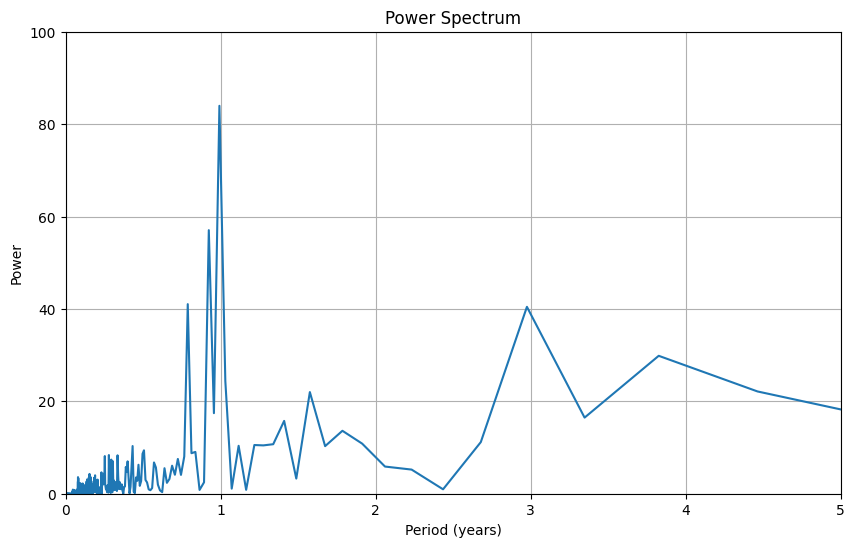

In [19]:
fourier_transform = np.fft.fft(chla_naive_avg)
power_spectrum = np.abs(fourier_transform)**2
frequencies = np.fft.fftfreq(len(chla_naive_avg), d=8)  # Assuming sampling frequency of 8 days

# Convert frequencies to periods
periods = 1 / frequencies
periods = periods[1:]  # Remove the first element to avoid division by zero

# Plot power vs period
plt.figure(figsize=(10, 6))
plt.plot(periods/365, power_spectrum[1:])
plt.xlabel('Period (years)')
plt.ylabel('Power')
plt.title('Power Spectrum')
plt.grid(True)
plt.xlim(0,5)
plt.ylim(0,100)
plt.show()


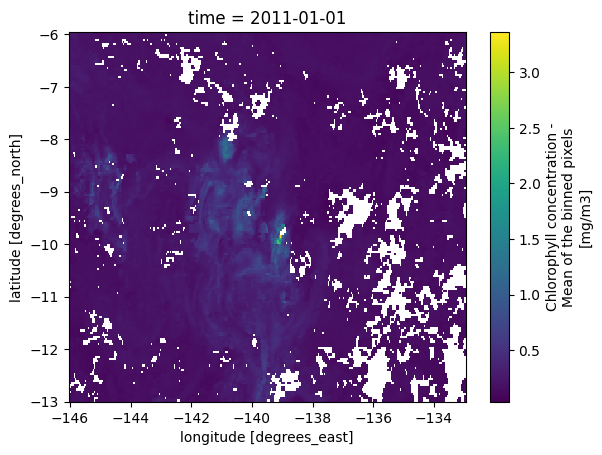

In [109]:
chla[np.argmax(chla_naive_avg.values)-3].plot()